<a href="https://colab.research.google.com/github/thmspfffr/Voice-classification/blob/main/voice_classification_ravdess.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
! pip install kaggle
! mkdir ~/.kaggle
! cp kaggle.json ~/.kaggle/
! chmod 600 ~/.kaggle/kaggle.json
! pip install nlpaug
! pip install sklearn

In [2]:
! kaggle datasets download -d uwrfkaggler/ravdess-emotional-speech-audio

 99% 425M/429M [00:22<00:00, 21.4MB/s]
100% 429M/429M [00:22<00:00, 20.2MB/s]


In [3]:
! mkdir data
! mkdir data/ravdess
! mv ravdess-emotional-speech-audio.zip data/ravdess


In [2]:
cd data/ravdess


/content/data/ravdess


In [ ]:
! unzip ravdess-emotional-speech-audio.zip

Actual code begins here

In [27]:
import numpy as np 
import pandas as pd 
from glob import glob
import librosa
import matplotlib.pyplot as plt
import tensorflow as tf
from tensorflow.keras import datasets, layers, models
from sklearn.metrics import confusion_matrix, accuracy_score, classification_report, plot_confusion_matrix
from sklearn.model_selection import StratifiedKFold
from sklearn.model_selection import train_test_split
import nlpaug.augmenter.audio as naa

# Modality (01 = full-AV, 02 = video-only, 03 = audio-only).
# Vocal channel (01 = speech, 02 = song).
# Emotion (01 = neutral, 02 = calm, 03 = happy, 04 = sad, 05 = angry, 06 = fearful, 07 = disgust, 08 = surprised).
# Emotional intensity (01 = normal, 02 = strong). NOTE: There is no strong intensity for the 'neutral' emotion.
# Statement (01 = "Kids are talking by the door", 02 = "Dogs are sitting by the door").
# Repetition (01 = 1st repetition, 02 = 2nd repetition).
# Actor (01 to 24. Odd numbered actors are male, even numbered actors are female).

audios = glob('*/*.wav')

mod = []; voc_chan = []; emo = []; emo_intens = []; repet = []; actor = []
for i in range(0,len(audios)):
    
    mod.append(int(audios[i].split('/')[-1][1]))
    voc_chan.append(int(audios[i].split('/')[-1][4]))
    emo.append(int(audios[i].split('/')[-1][7]))
    emo_intens.append(int(audios[i].split('/')[-1][10]))
    repet.append(int(audios[i].split('/')[-1][13]))
    actor.append(int(audios[i].split('/')[-1][18:19]))
    
    
# MINIMUM LENGTH: 64745 samples    
# lens = len(audios)*[None] 
# for i in range(0,len(audios)):
#     print(i,end=' ')
#     lens[i]=librosa.load(audios[i])[0].shape[0]
# min_length = min(lens)
min_length = 64745

d = {'Modality': mod, 'Channel': voc_chan, 'Emotion': emo, 'Emotional_Intensity': emo_intens, 'Repetition': repet, 'Actor': actor, 'Filename': audios}
df = pd.DataFrame(data=d)

del mod, voc_chan, emo, emo_intens, actor, repet

Two functions for processing the audio data

In [ ]:
# Audio noise augmentation
aug = naa.NoiseAug()

def convert_to_melspec(path,add_noise=False,aug=None):
    audio_data, sr = librosa.load(path)
    idx = int(np.floor((audio_data.shape[0]-min_length)/2))
    audio_data = audio_data[idx+1:-idx-1]
    if add_noise==True:
      audio_data = np.array(aug.augment(audio_data)[0])
    Sxx  = librosa.feature.melspectrogram(y=audio_data, sr=sr,n_fft =512,win_length=128,hop_length=128)
    S_dB = librosa.power_to_db(Sxx, ref=np.max)
    return S_dB

def zscore(data):
    m = data.reshape(np.prod(data.shape)).mean()
    s = data.reshape(np.prod(data.shape)).std()
    data=(data-m)/s
    return data, m, s
    
data=np.zeros([128,506,len(audios)-1])
for i in range(0,len(audios)-1):
    print(i,end = ' ')
    data[:,:,i]=convert_to_melspec(audios[i])

data = np.transpose(data, (2,1,0))

X, m, s = zscore(data)

y = df['Emotion'][0:-1]-1

del data

Plot the result

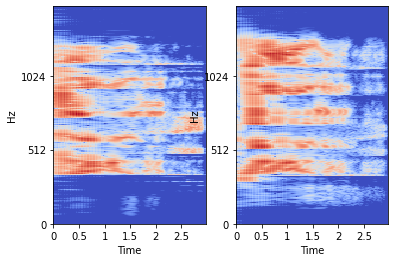

In [25]:
audio_data, sr = librosa.load(audios[0])

import librosa.display

fig, (ax1,ax2) = plt.subplots(1,2)

img = librosa.display.specshow(X[0,:,:], x_axis='time', y_axis='mel', sr=sr, fmax=2000, ax=ax1)
img = librosa.display.specshow(X[1000,:,:], x_axis='time', y_axis='mel', sr=sr, fmax=2000, ax=ax2)

### First approach: regular neural network

1st layer: 128 units

2nd layer: 64 units

Output layer: 8 units

In [ ]:
X_train, X_test, y_train, y_test = train_test_split(X,y,test_size=0.2,train_size=0.8)

model = models.Sequential() 
model.add(layers.Flatten(input_shape=(X_train.shape[1], X_train.shape[2])))
model.add(layers.Dense(128, activation='relu')) 
model.add(layers.Dense(64, activation='relu')) 
model.add(layers.Dense(8))

model.compile(optimizer='adam',
          loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True),
          metrics=['accuracy'])

history = model.fit(X_train, y_train, epochs=100,validation_data=(X_test, y_test),batch_size=32)

test_loss, test_acc = model.evaluate(X_test,  y_test, verbose=2)


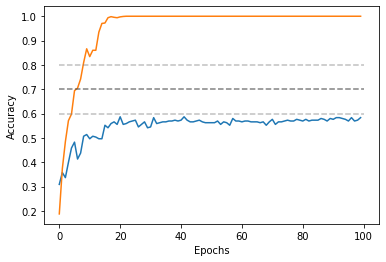

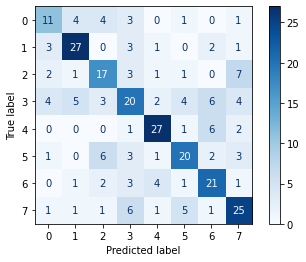

In [38]:
f, ax1 = plt.subplots(1,1)

ax1.plot(history.history['val_accuracy'])
ax1.plot(history.history['accuracy'])
ax1.plot([0,100],[0.6,0.6],linestyle='--',color=[0.5, 0.5, 0.5],alpha=0.5)
ax1.plot([0,100],[0.7,0.7],linestyle='--',color=[0.3, 0.3, 0.3],alpha=0.7)
ax1.plot([0,100],[0.8,0.8],linestyle='--',color=[0.5, 0.5, 0.5],alpha=0.5)

ax1.set_xlabel('Epochs')
ax1.set_ylabel('Accuracy')

import matplotlib.cm
from sklearn.metrics import ConfusionMatrixDisplay

f, ax2 = plt.subplots(1,1)

cmap = matplotlib.cm.get_cmap('Blues')

y_pred = model.predict(X_test)
y_pred = np.argmax(y_pred,axis=1)
cm = confusion_matrix(y_pred,y_test)

disp = ConfusionMatrixDisplay(confusion_matrix=cm)
disp.plot(cmap=cmap,ax=ax2)

Model very **quickly overfits** and performance stays well below 60%. Not bad for a very simple network with minimal preprocessing, but also far from SOTA (~82% accuracy).

In [ ]:
# CONVOLUTIONAL NEURAL NETWORK 
# ---------------------
X_train, X_test, y_train, y_test = train_test_split(X,y,test_size=0.2,train_size=0.8)

y_test = tf.stack(y_test)
y_train = tf.stack(y_train)

X_train = tf.expand_dims(X_train, axis=-1)
X_test = tf.expand_dims(X_test, axis=-1)

model = models.Sequential() 
model.add(layers.Conv2D(16, (2, 2), activation='relu', input_shape=(X_train.shape[1], X_train.shape[2],1))) 
model.add(layers.MaxPooling2D((2, 2))) 
model.add(layers.Conv2D(32, (2, 2), activation='relu')) 
model.add(layers.MaxPooling2D((2, 2))) 
model.add(tf.keras.layers.Dropout(0.2))
model.add(layers.Conv2D(128, (3, 3), activation='relu')) 
model.add(layers.MaxPooling2D((3, 3))) 
model.add(tf.keras.layers.Dropout(0.2))
model.add(layers.Conv2D(256, (3, 3), activation='relu')) 
model.add(layers.MaxPooling2D((3, 3))) 
model.add(tf.keras.layers.Dropout(0.2))
model.add(tf.keras.layers.GlobalAveragePooling2D())
model.add(layers.Dense(8))

model.compile(optimizer='adam',
              loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True),
              metrics=['accuracy'])

history = model.fit(X_train, y_train, epochs=100,validation_data=(X_test, y_test),batch_size=64)

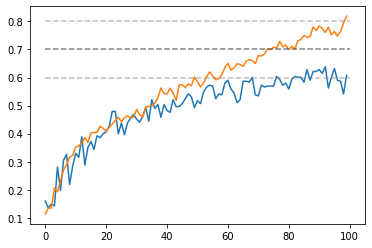

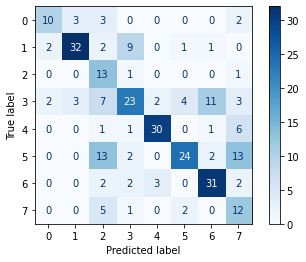

In [46]:
f, ax1 = plt.subplots(1,1)

ax1.plot(history.history['val_accuracy'])
ax1.plot(history.history['accuracy'])
ax1.plot([0,100],[0.6,0.6],linestyle='--',color=[0.5, 0.5, 0.5],alpha=0.5)
ax1.plot([0,100],[0.7,0.7],linestyle='--',color=[0.3, 0.3, 0.3],alpha=0.7)
ax1.plot([0,100],[0.8,0.8],linestyle='--',color=[0.5, 0.5, 0.5],alpha=0.5)

# ax1.xlabel('Epochs')
# ax1.ylabel('Accuracy')

import matplotlib.cm
from sklearn.metrics import ConfusionMatrixDisplay

f, ax2 = plt.subplots(1,1)

cmap = matplotlib.cm.get_cmap('Blues')

y_pred = model.predict(X_test)
y_pred = np.argmax(y_pred,axis=1)
cm = confusion_matrix(y_pred,y_test)

disp = ConfusionMatrixDisplay(confusion_matrix=cm)
disp.plot(cmap=cmap,ax=ax2)

The model seems to hit a performance ceiling at a **validation accuracy of around 60%**. Not too bad but also not quite competetive: SOTA architectures reach 80+% classification accuracy on this dataset. It is also evident that the model is overfitting quite a bit. Performance of the CNN is a bit better than the performance of the regular NN, but the difference isn't all too big. Main problem likely is the low number of samples (N=1440). One way to alleviate this issue is data augumentation, which is implemented in the next steps. 

Labels 2 (happy) and 3 (sad) are particularly bad. The simple NN didn't seem to struggle with those. 

**Emotion** (01 = neutral, 02 = calm, 03 = happy, 04 = sad, 05 = angry, 06 = fearful, 07 = disgust, 08 = surprised).


---



In [ ]:
# # Audio noise augmentation

y = np.zeros([len(audios)-1,1])
y_aug = np.zeros([3*(len(audios)-1),1])
data=np.zeros([128,506,len(audios)-1])
data_aug=np.zeros([128,506,3*(len(audios)-1)])

for i in range(0,len(audios)-1):
    print(i,end = ' ')
    data[:,:,i]   = convert_to_melspec(audios[i])
    data_aug[:,:,i*3]   = np.flip(data[:,:,i],axis=1)
    data_aug[:,:,1+i*3] = convert_to_melspec(audios[i],add_noise=True,aug=aug)
    data_aug[:,:,2+i*3] = np.flip(data_aug[:,:,1+i*3],axis=1)

    y[i,0] = df['Emotion'][i]-1
    y_aug[i*3,0]   = df['Emotion'][i]-1
    y_aug[1+i*3,0] = df['Emotion'][i]-1
    y_aug[2+i*3,0] = df['Emotion'][i]-1

data = np.transpose(data, (2,1,0))
data_aug = np.transpose(data_aug, (2,1,0))

X = data
X_train, X_test, y_train, y_test = train_test_split(X,y,test_size=0.4,train_size=0.6)
X_test, X_dev, y_test, y_dev = train_test_split(X_test,y_test,test_size=0.5,train_size=0.5)

X_train = np.append(X_train,data_aug,axis=0)
y_train = np.append(y_train,y_aug,axis=0)

X_train, m, s = zscore(X_train)

X_test = (X_test-m)/s
X_dev = (X_dev-m)/s

# del data

Text(0.5, 0, 'Time')

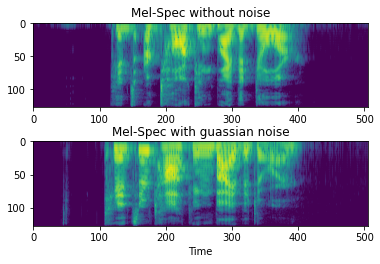

In [50]:
f, (ax1, ax2) = plt.subplots(2,1)

ax1.imshow(np.array(X_dev[0,:,:]).transpose())
ax1.set_title("Mel-Spec without noise")
ax2.imshow(X_train[0,:,:].transpose())
ax2.set_title("Mel-Spec with guassian noise")
ax2.set_xlabel("Time")


In [ ]:
# CONVOLUTIONAL NEURAL NETWORK 
# ---------------------

y_dev = tf.stack(y_dev)
y_train = tf.stack(y_train)

X_train = tf.expand_dims(X_train, axis=-1)
X_dev = tf.expand_dims(X_dev, axis=-1)

model = models.Sequential() 
model.add(layers.Conv2D(16, (2, 2), activation='relu', input_shape=(X_train.shape[1], X_train.shape[2],1))) 
model.add(layers.MaxPooling2D((2, 2))) 
model.add(layers.Conv2D(32, (2, 2), activation='relu')) 
model.add(layers.MaxPooling2D((2, 2))) 
model.add(tf.keras.layers.Dropout(0.2))
model.add(layers.Conv2D(128, (3, 3), activation='relu')) 
model.add(layers.MaxPooling2D((3, 3))) 
model.add(layers.Conv2D(256, (3, 3), activation='relu')) 
model.add(layers.MaxPooling2D((3, 3))) 
model.add(tf.keras.layers.Dropout(0.2))
model.add(tf.keras.layers.GlobalAveragePooling2D())
model.add(layers.Dense(8))

model.compile(optimizer='adam',
              loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True),
              metrics=['accuracy'])

history = model.fit(X_train, y_train, epochs=100,validation_data=(X_dev, y_dev),batch_size=32)

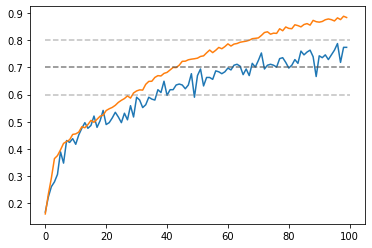

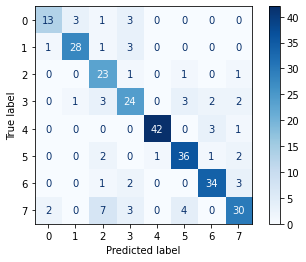

In [126]:
f, ax1 = plt.subplots(1,1)

ax1.plot(history.history['val_accuracy'])
ax1.plot(history.history['accuracy'])
ax1.plot([0,100],[0.6,0.6],linestyle='--',color=[0.5, 0.5, 0.5],alpha=0.5)
ax1.plot([0,100],[0.7,0.7],linestyle='--',color=[0.3, 0.3, 0.3],alpha=0.7)
ax1.plot([0,100],[0.8,0.8],linestyle='--',color=[0.5, 0.5, 0.5],alpha=0.5)

import matplotlib.cm
from sklearn.metrics import ConfusionMatrixDisplay

f, ax2 = plt.subplots(1,1)

cmap = matplotlib.cm.get_cmap('Blues')

y_pred = model.predict(X_test)
y_pred = np.argmax(y_pred,axis=1)
cm = confusion_matrix(y_pred,y_test)

disp = ConfusionMatrixDisplay(confusion_matrix=cm)
disp.plot(cmap=cmap,ax=ax2)

Adding data aufmentation (flipping the spectra as well as adding noise to the audio recordings) improves performance even further to **around 80% accuracy**, which seems quite close to SOTA implementations with similar architecutre and preprocessing. 

**Emotion** (0 = neutral, 1 = calm, 2 = happy, 3 = sad, 4 = angry, 5 = fearful, 6 = disgust, 7 = surprised).

In [175]:
from sklearn.metrics import recall_score,precision_score

recall = recall_score(y_test, y_pred, average='macro')
precision = precision_score(y_test, y_pred, average='macro')

print('Recall: %.3f' %recall)
print('Precision: %.3f' %precision)


Recall: 0.797
Precision: 0.793
